D'après une étude VIF, il faudrait supprimer les colonnes ZipCode, Latitude, Longitude

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection

import math
# Evaluate
from sklearn.metrics import r2_score,max_error,mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

# Preprocessing

In [3]:
df = pd.read_csv("data/data_cleaned.csv")
df.drop(['ZipCode','Latitude', 'Longitude'], axis=1, inplace=True)

In [6]:
df = pd.read_csv("data/2016_Building_Energy_Benchmarking.csv")
df.drop(['ZipCode','Latitude', 'Longitude'], axis=1, inplace=True)

In [7]:
df

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,CouncilDistrictCode,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,0659000030,7,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,0659000220,7,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,0659000475,7,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,0659000640,7,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,0659000970,7,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,1624049080,2,...,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,3558300000,2,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,1794501150,7,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,7883603155,1,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


In [8]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'GHGEmission

## Préparation de la donnée

* X train et test*

Nous allons scale certaines données, et encoder les données catégoriques :

Données à scale : 'CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge'

Donnée à encoder : 'BuildingType', 'PrimaryPropertyType', 'Neighborhood'

### Scaling des données

In [4]:
X_to_scale = df.drop(['TotalGHGEmissions', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood'], axis=1)

#### Compléter ENERGYSTARScore

In [5]:
print(f'Il y a actuellement {X_to_scale.isna().sum()[4]} valeurs NaN dans ENERGYSTARScore')

Il y a actuellement 560 valeurs NaN dans ENERGYSTARScore


In [6]:
imputer = KNNImputer(n_neighbors=5)

energystar = X_to_scale.values
new_X_to_scale = pd.DataFrame(imputer.fit_transform(energystar), columns = X_to_scale.columns)

In [7]:
print(f'Il y a actuellement {new_X_to_scale.isna().sum()[4]} valeurs NaN dans ENERGYSTARScore')

Il y a actuellement 0 valeurs NaN dans ENERGYSTARScore


#### Continuation du scaling

In [8]:
to_scale = new_X_to_scale.values

In [9]:
X_to_encode = df.drop(['TotalGHGEmissions',  'CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal',
                       'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge'], axis = 1)

In [10]:
#X = df.drop('TotalGHGEmissions', axis=1)
y = df['TotalGHGEmissions']

#### Scaling

In [11]:
rs = MinMaxScaler()
rs = rs.fit(to_scale)
to_scale = rs.transform(to_scale)

In [12]:
X_scaled = pd.DataFrame(to_scale, columns = X_to_scale.columns)

In [13]:
X_scaled

,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SteamUse(kBtu),BuildingAge
0,1.000000,0.121212,0.008288,0.000000,0.595960,0.014850,0.765217
1,1.000000,0.111111,0.009913,0.029387,0.606061,0.000000,0.165217
2,1.000000,0.414141,0.101497,0.383759,0.424242,0.159819,0.400000
3,1.000000,0.101010,0.005375,0.000000,0.555556,0.016410,0.773913
4,1.000000,0.181818,0.017649,0.120950,0.747475,0.000000,0.304348
...,...,...,...,...,...,...,...
1634,0.166667,0.010101,0.000108,0.000000,0.454545,0.000000,0.217391
1635,0.166667,0.010101,0.000507,0.000000,0.660606,0.000000,0.095652
1636,1.000000,0.010101,0.000201,0.000000,0.660606,0.000000,0.356522
1637,0.000000,0.010101,0.000303,0.000000,0.660606,0.000000,0.226087


#### Encoding

In [14]:
# OneHotEncoder
ohe = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(ohe.fit_transform(X_to_encode), columns=ohe.get_feature_names())

# One-hot encoding removed index; put it back
OH_cols.index = X_to_encode.index

num_trainset = X_to_encode.drop(columns={'BuildingType', 'PrimaryPropertyType', 'Neighborhood'}, axis = 1)

# Add one-hot encoded columns to numerical features
X_encoded = pd.concat([num_trainset, OH_cols], axis=1)
X_encoded

,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_Distribution Center,x1_Hospital,x1_Hotel,x1_K-12 School,x1_Laboratory,x1_Large Office,...,x2_DOWNTOWN,x2_EAST,x2_GREATER DUWAMISH,x2_LAKE UNION,x2_MAGNOLIA / QUEEN ANNE,x2_NORTH,x2_NORTHEAST,x2_NORTHWEST,x2_SOUTHEAST,x2_SOUTHWEST
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1635,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1636,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1637,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Assemblage des DataFrames

In [15]:
X = pd.concat([X_scaled, X_encoded], axis=1)

In [16]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y,test_size=0.3)

# Modélisation

In [17]:
results = pd.DataFrame(columns=['Modèle','RMSE','Inference_duration (microsecs)'])

## RandomForest Regressor

In [18]:
parameters = {
    'n_estimators' : [10,50,100,300,500],
    'min_samples_leaf' : [1,3,5,10], 
    'max_features': ['auto', 'sqrt']
}

In [19]:
rfr = GridSearchCV(RandomForestRegressor(), param_grid = parameters, verbose=True, cv=5)
rfr.fit(X_train, Y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=True)

In [20]:
rfr.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

In [21]:
#results = results.append({
#    'Modèle' : 'Random Forest',
#    'RMSE' : rmse_estimator_rfr,
#    }
#    ,ignore_index=True)

In [22]:
results

,Modèle,RMSE,Inference_duration (microsecs)


In [23]:
coefficients = abs(rfr.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variables']), 
                      pd.DataFrame(coefficients, columns = ['Coefficients'])), axis = 1).sort_values(by='Coefficients', ascending = False)

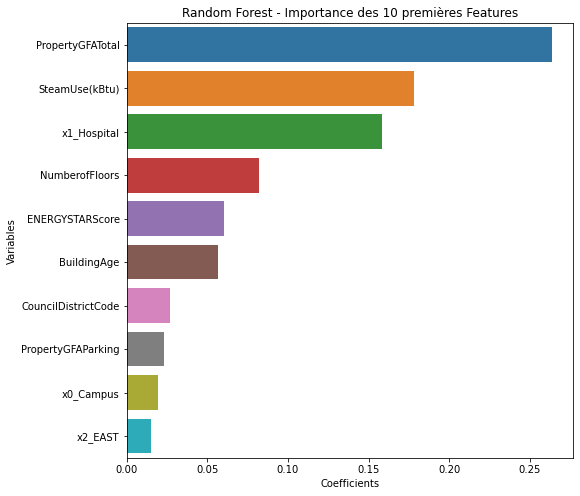

In [24]:
plt.figure(figsize=(8,8))
plt.title('Random Forest - Importance des 10 premières Features')
sns.barplot(y = liste_coefs_rer['Variables'].head(10),
            x = liste_coefs_rer['Coefficients'].head(10))
plt.show()

In [25]:
y_pred = rfr.predict(X_test)

In [26]:
Y_test.describe()

count      492.000000
mean       245.338069
std       1088.013970
min          0.400000
25%         23.265000
50%         53.765000
75%        163.350000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [27]:
verif = pd.DataFrame(data=Y_test)
verif['y_pred'] = y_pred

verif.columns = ['Y_test','y_pred']

In [28]:
verif.y_pred.describe()

count     492.000000
mean      182.597735
std       417.633304
min         8.941867
25%        46.695983
50%        77.097567
75%       182.396617
max      5980.089633
Name: y_pred, dtype: float64

In [29]:
print("R²:", r2_score(Y_test, y_pred))
print("MAE:", mean_absolute_error(Y_test, y_pred))
#print("MSE:", mean_squared_error(Y_test, y_pred))
print("RMSE:", mean_squared_error(Y_test, y_pred, squared=False))

R²: 0.38677527496539454
MAE: 158.52867730352307
RMSE: 851.1429279984604


In [30]:
Y_test

1115      37.08
483      357.39
1089      13.70
1546      37.83
344       22.44
         ...   
1530      21.05
1205     108.05
251     1084.79
899       11.97
1349      14.21
Name: TotalGHGEmissions, Length: 492, dtype: float64

In [41]:
best_rfr = RandomForestRegressor(max_features="sqrt", min_samples_leaf=1, n_estimators = 300)
best_rfr.fit(X_train, Y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=300)

In [42]:
y_pred_best = best_rfr.predict(X_test)

In [43]:
print("R²:", r2_score(Y_test, y_pred_best))
print("MAE:", mean_absolute_error(Y_test, y_pred_best))
#print("MSE:", mean_squared_error(Y_test, y_pred))
print("RMSE:", mean_squared_error(Y_test, y_pred_best, squared=False))

R²: 0.39077767539194375
MAE: 159.38607886178866
RMSE: 848.3607573897466


## XGboostRegressor

In [44]:
from xgboost import XGBRegressor

In [45]:
parameters = {
    'n_estimators' : [10,20,50,100,500,1000,2000]
}
xgb = GridSearchCV(XGBRegressor(),
                        param_grid = parameters,
                        cv = 5,
                        verbose=False)
xgb.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [46]:
xgb.best_params_

{'n_estimators': 10}

In [47]:
best_xgb = XGBRegressor(n_estimators = 10, booster="gblinear")
best_xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=4, num_parallel_tree=None, predictor=None,
             random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

In [50]:
xgb_pred = best_xgb.predict(X_test)

print("R²:", r2_score(Y_test, xgb_pred))
print("MAE:", mean_absolute_error(Y_test, xgb_pred))
#print("MSE:", mean_squared_error(Y_test, xgb_pred))
print("RMSE:", mean_squared_error(Y_test, xgb_pred, squared=False))

R²: 0.48815689622437286
MAE: 149.82680803213663
RMSE: 777.6086707826812


In [51]:
XGBRegressor.feature_importances_

## SHAP values